# EE 658/758 Machine Learning in Engineering

## Assignment 1: Linear Regression

In [1]:
# Import necessary libraries
import os
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from scipy.stats import norm

### 1.Data Preprocessing:

In [2]:
file_path = 'insurance.csv'
sample_size = 10
data = pd.read_csv(file_path)
data.head()

,Age,Gender,BMI,Children,Smoker,Region,Expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:


num_rows_with_missing_values = data.isna().any(axis=1).sum()

print(f"Number of rows with missing values: {num_rows_with_missing_values}")

Number of rows with missing values: 17


In [4]:
for col_name in data.columns:
    # Check if there are missing values in the column
    if data[col_name].isnull().any():
        # Fill missing values in categorical columns using mode, and numeric columns using mean
        if data[col_name].dtype == 'object':  # Categorical column
            mode_value = data[col_name].mode()[0]
            data[col_name].fillna(mode_value, inplace=True)
        else:  # Numeric column
            mean_value = data[col_name].mean()
            data[col_name].fillna(mean_value, inplace=True)

# Binary Encoding for categorical columns with 2 unique values
data = pd.get_dummies(data, drop_first=True)

# One-Hot Encoding for categorical columns with more than 2 unique values
data = pd.get_dummies(data)

# Display the modified DataFrame
data

,Age,BMI,Children,Expenses,Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
0,19,27.900000,0,16884.92,0,1,0,0,1
1,18,33.800000,1,1725.55,1,0,0,1,0
2,28,33.000000,3,4449.46,1,0,0,1,0
3,33,22.700000,0,21984.47,1,0,1,0,0
4,32,28.900000,0,3866.86,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,31.000000,3,10600.55,1,0,1,0,0
1334,18,31.900000,0,2205.98,1,0,0,0,0
1335,18,30.676917,0,1629.83,0,0,0,1,0
1336,21,25.800000,0,2007.95,0,0,0,0,1


In [5]:
columns_to_normalize = ['Age', 'BMI', 'Children', 'Expenses']

scaler = MinMaxScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

data.head()

,Age,BMI,Children,Expenses,Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
0,0.021739,0.320755,0.481481,0.251611,0,1,0,0,1
1,0.000000,0.479784,0.488889,0.009636,1,0,0,1,0
2,0.217391,0.458221,0.503704,0.053115,1,0,0,1,0
3,0.326087,0.180593,0.481481,0.333010,1,0,1,0,0
4,0.304348,0.347709,0.481481,0.043816,1,0,1,0,0


### 2.Splitting the data:

In [6]:
# Features are all columns except 'Expenses'
features = data.drop(columns=['Expenses'])

# Target is the 'Expenses' column
target = data['Expenses']

# Display the features and target
print("Features:")
print(features.head())

print("\nTarget:")
print(target.head())

Features:
        Age       BMI  Children  Gender_male  Smoker_yes  Region_northwest  \
0  0.021739  0.320755  0.481481            0           1                 0   
1  0.000000  0.479784  0.488889            1           0                 0   
2  0.217391  0.458221  0.503704            1           0                 0   
3  0.326087  0.180593  0.481481            1           0                 1   
4  0.304348  0.347709  0.481481            1           0                 1   

   Region_southeast  Region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  

Target:
0    0.251611
1    0.009636
2    0.053115
3    0.333010
4    0.043816
Name: Expenses, dtype: float64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Display the shapes of the training and testing sets
print("Training set - Features shape:", X_train.shape)
print("Testing set - Features shape:", X_test.shape)
print("Training set - Target shape:", y_train.shape)
print("Testing set - Target shape:", y_test.shape)

Training set - Features shape: (1003, 8)
Testing set - Features shape: (335, 8)
Training set - Target shape: (1003,)
Testing set - Target shape: (335,)


### 3.Gradient Descent Implementation:
Implement the gradient descent algorithm (without the Scikit-Learn library) to find the regression line. Initialize parameters randomly and update them iteratively to minimize the loss function. Record the loss value for each iteration:

#### show the coefficients and intercept of the model:

In [8]:
N_train, D_train = X_train.shape
N_test, D_test = X_test.shape

# Ensure both training and test sets have the same number of features
D_train == D_test, "Number of features in training and test sets must match"

# Reshape bias to have the same number of rows as X
train_bias = np.ones((N_train, 1))
test_bias = np.ones((N_test, 1))

# Concatenate bias column to the training and test data
X_bias_train = np.concatenate((X_train, train_bias), axis=1)
X_bias_test = np.concatenate((X_test, test_bias), axis=1)

alpha = 0.01                  # Learning rate
n_iterations = 10000   # Number of iterations
W = np.random.randn(D_train+1)  # Weight matrix

loss = []                          # Loss value for each iteration
for iteration in range(n_iterations):
    # Calculate gradients
    gradients = 1/N_train * X_bias_train.T.dot(X_bias_train.dot(W) - y_train)
    
    # Update weights using gradients
    W = W - alpha * gradients
    
    # Calculate predictions and loss
    predictions = X_bias_train.dot(W)
    loss.append(mean_squared_error(y_train, predictions))

# Coefficients of the model
coefficients = W[:-1]
intercept = W[-1]

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.20052245  0.03897394 -0.01526573  0.00038553  0.37617007 -0.00090051
  0.00861438 -0.00286272]
Intercept: 0.015583795239775211


#### Modify the code to implement the exponential decay method for the learning rate:

In [9]:
# Set up variables
costs_decaying = []
learning_rate_decaying = 0.001
decay_rate = 0.1
num_iterations = 100

# Randomly initialize weights
w_decay = np.random.randn(D_train + 1) / np.sqrt(D_train + 1)

# Define the iteration numbers
t = 100
for i in range(t):
    # Perform the updates without using a for loop
    Yhat_train_decaying = X_bias_train.dot(w_decay)
    delta_train_decaying = Yhat_train_decaying - y_train
    w_decay = w_decay - learning_rate_decaying * X_bias_train.T.dot(delta_train_decaying)

    # Calculate and store the cost for decaying learning rate
    mse_train_decaying = np.mean(delta_train_decaying ** 2)
    costs_decaying.append(mse_train_decaying)
     # Calculate the decaying learning rate
    learning_rate_decaying *= (1.0 / (1.0 + decay_rate * i))


print(f"Coefficient: {w_decay[:-1]}")
print(f"intecept: {w_decay[-1]}")

Coefficient: [ 0.14360727  0.51515865 -0.27732445 -0.04504583  0.36105489 -0.08881111
 -0.00689888 -0.05575751]
intecept: 0.0507056371860053


#### Plot the loss values as a function of the number of iterations for the constant and decaying learning rates.

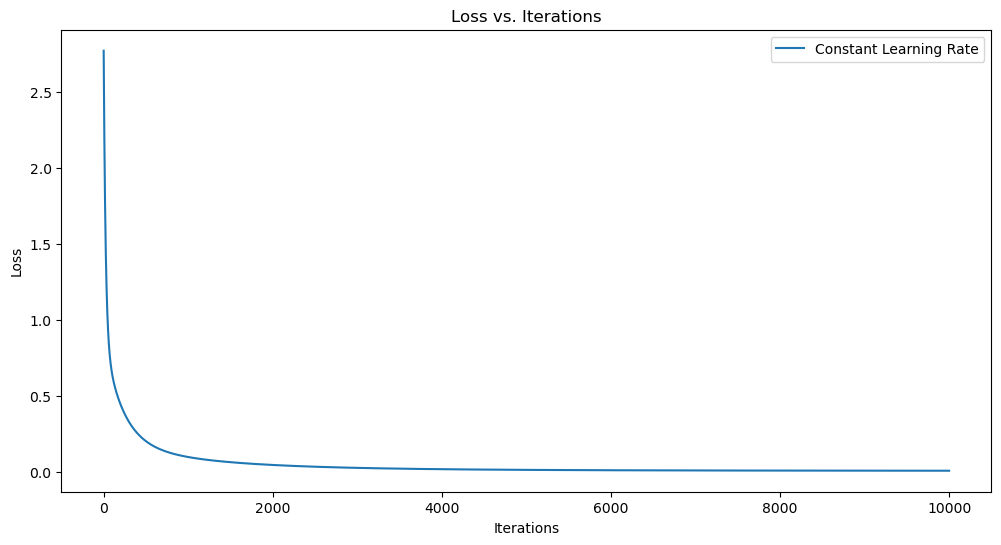

In [10]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plot the loss values for constant learning rate
plt.plot(loss, label='Constant Learning Rate')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()

# Show the plot
plt.show()

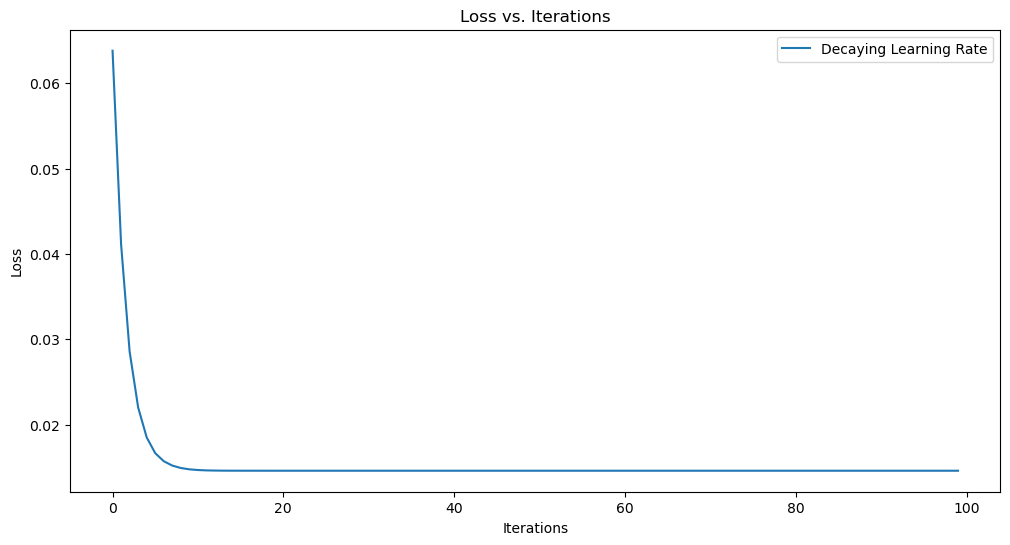

In [11]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plot the loss values for decaying learning rate
plt.plot(costs_decaying, label='Decaying Learning Rate')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()

# Show the plot
plt.show()

### 4. Predict the expenses for the testing dataset using the trained model.
Compute the Mean Absolute Error (MAE) and Mean Squared Error (MSE) of the predictions.

In [12]:
y_pred_constant = X_bias_test.dot(W)

print(f"Mean Squared Error with constant Learning Rate: {mean_squared_error(y_test, y_pred_constant)}")
print(f"Mean Absolute Error with constant Learning Rate: {mean_absolute_error(y_test, y_pred_constant)}")
print()

y_pred_decay = X_bias_test.dot(w_decay)

print()
print(f"Mean Squared Error with decaying Learning Rate: {mean_squared_error(y_test, y_pred_decay)}")
print(f"Mean Absolute Error with decaying Learning Rate: {mean_absolute_error(y_test, y_pred_decay)}")

Mean Squared Error with constant Learning Rate: 0.009758820333597745
Mean Absolute Error with constant Learning Rate: 0.06501497813878306


Mean Squared Error with decaying Learning Rate: 0.014500371259615511
Mean Absolute Error with decaying Learning Rate: 0.0954256243225537


#### Plot a histogram of the error distribution.

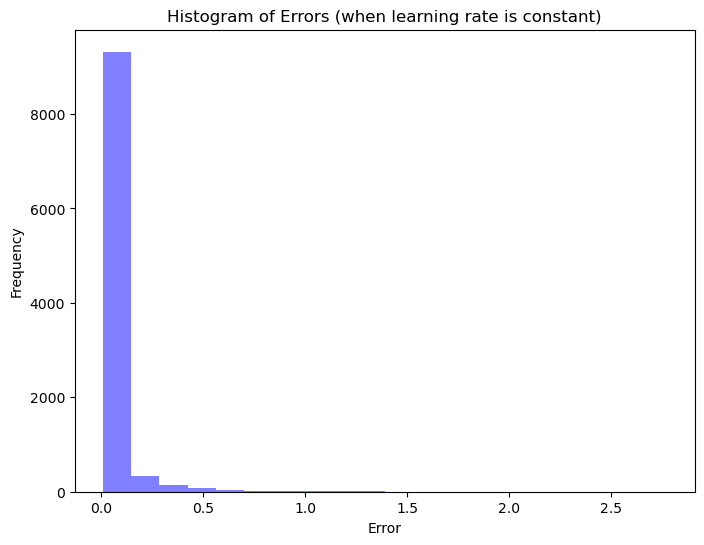

In [13]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(loss, bins=20, color='blue', alpha=0.5)
plt.title('Histogram of Errors (when learning rate is constant)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

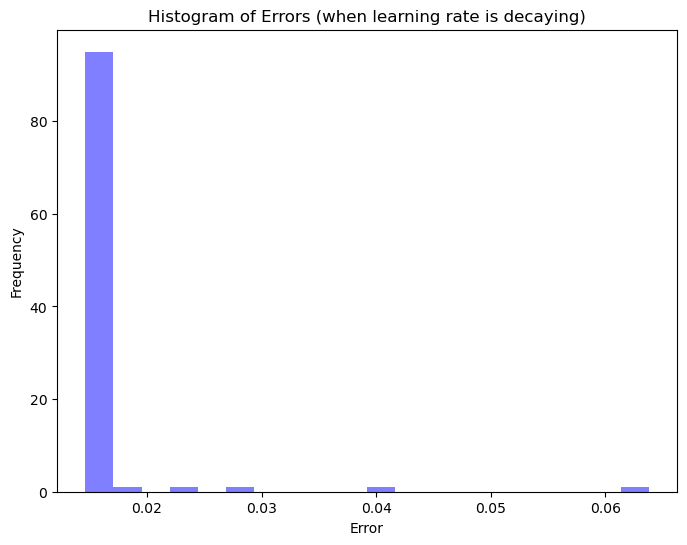

In [14]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(costs_decaying, bins=20, color='blue', alpha=0.5)
plt.title('Histogram of Errors (when learning rate is decaying)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

### 5. Learning Rate Analysis:
Demonstrate the effect of varying the learning rate on the convergence of the gradient descent algorithm

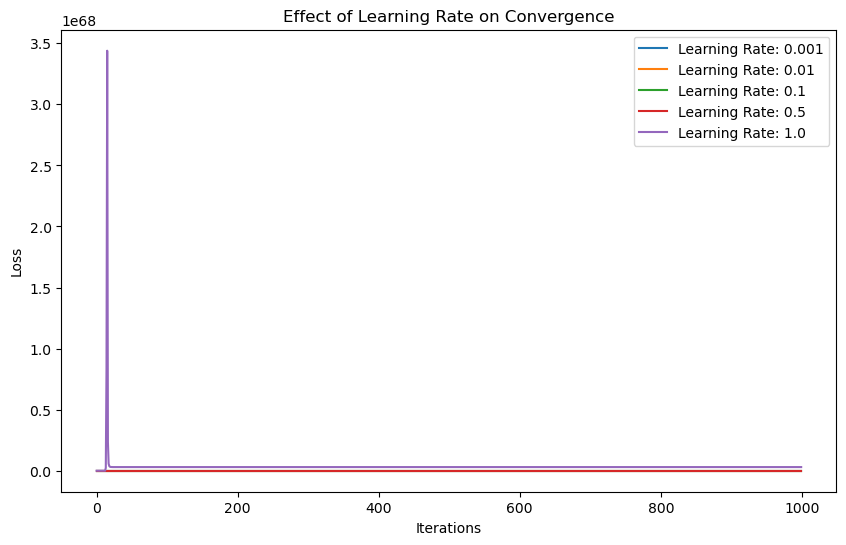

In [15]:
# Function to train the LinearRegression model with different learning rates and plot the loss curve
def train_and_plot_learning_rate_effect(X_train, y_train, learning_rates):
    plt.figure(figsize=(10, 6))
    for initial_learning_rate in learning_rates:
        # Initialize weights randomly
        D_train = X_train.shape[1]
        w_decay = np.random.randn(D_train + 1) / np.sqrt(D_train + 1)
        
        costs_decaying = []
        decay_rate = 0.1
        learning_rate = initial_learning_rate
        
        for t in range(1000):
            # Append bias term to features
            bias = np.ones((X_train.shape[0], 1))
            X_bias_train = np.concatenate((X_train, bias), axis=1)

            # Update weights with decaying learning rate
            Yhat_train_decaying = X_bias_train.dot(w_decay)
            delta_train_decaying = Yhat_train_decaying - y_train
            w_decay = w_decay - learning_rate * X_bias_train.T.dot(delta_train_decaying)

            # Find and store the cost for decaying learning rate
            mse_train_decaying = np.mean(delta_train_decaying ** 2)
            costs_decaying.append(mse_train_decaying)

            # Update learning rate with exponential decay
            learning_rate *= (1.0 / (1.0 + decay_rate * t))

        # Plot the loss curve for the current learning rate
        iterations = np.arange(len(costs_decaying))
        plt.plot(iterations, costs_decaying, label=f'Learning Rate: {initial_learning_rate}')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Effect of Learning Rate on Convergence')
    plt.legend()
    plt.show()

# Example usage:
# Assuming X_train and y_train are the training features and target respectively
# Define a range of learning rates to test
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]

# Call the function to train and plot the effect of different learning rates
train_and_plot_learning_rate_effect(X_train, y_train, learning_rates)

## 6. Scikit-learn Implementation:
Repeat the regression using the linear_model.LinearRegression class from scikit-learn.

Compute MAE and MSE for comparison.

In [16]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Mean Squared Error: 0.009041340761262135
Mean Absolute Error: 0.06810533992326168


### 7. Normal Equation Implementation:
Use the normal equation method to find the regression line directly.

In [17]:
w = np.linalg.solve(np.dot(X_bias_train.T, X_bias_train), np.dot(X_bias_train.T, y_train))
Yhat = np.dot(X_bias_train, w)


# determine how good the model is by computing the r-squared
d1 = y_train - Yhat
d2 = y_train - y_train.mean()
r2 = 1 - d1.dot(d1) / d2.dot(d2)
print("the r-squared for train data is:", r2)

the r-squared for train data is: 0.7433347546449494


In [18]:
w = np.linalg.solve(np.dot(X_bias_test.T, X_bias_test), np.dot(X_bias_test.T, y_test))
Yhat = np.dot(X_bias_test, w)


# determine how good the model is by computing the r-squared
d1 = y_test - Yhat
d2 = y_test - y_test.mean()
r2 = 1 - d1.dot(d1) / d2.dot(d2)
print("the r-squared for test data is:", r2)

the r-squared for test data is: 0.7706512905011024


#### Compare the MAE and MSE with previous methods

#### 1. The values of MSE determined from Normal equation implementation are

The Mean Squared Error for train data is: 0.7433347546449494

The Mean Squared Error for test data is: 0.7706512905011024

#### 2. The values of MAE and MSE obtained by Scikit-learn Implementation are:

Mean Absolute Error: 0.06810533992326168

Mean Squared Error: 0.009041340761262135

#### 3. Values of MAE and MSE obtained by Predicting the expenses for the testing dataset using the trained model are:

#### The MAE and MSE for gradient descent algorithm:(constant learning rate)

Mean Absolute Error: 0.06957346520019507

Mean Squared Error: 0.010741474013340246

#### The MAE and MSE for exponential decay method:

Mean Absolute Error: 0.12043742044873948

Mean Squared Error: 0.023359615667354897

* The Scikit-Learn implementation achieved the lowest MAE and MSE, indicating it is the most accurate among the methods.
* The Gradient Descent algorithm performed slightly worse than Scikit-Learn in terms of both MAE and MSE.
* The Normal Equation Implementation performed better than the Gradient Descent Algorithm in terms of MSE but worse in terms of MAE.
* The Exponential Decay Method performed the worst in terms of both MAE and MSE

So in terms of accuracy, the methods can be ranked:

Scikit-Learn, Gradient Descent, Normal Equation, Exponential Decay.

### 8. Comparison

#### Compare the three solutions in terms of MAE, MSE, and computational efficiency.


#### Gradient Descent with Constant Learning Rate:

MAE: 0.0695

MSE: 0.0107

Computational Efficiency: Medium

* It requires iterating over a fixed number of iterations (10,000 in this case), which might be computationally expensive for large datasets. However, it has the advantage of being able to handle large datasets efficiently due to its iterative nature.

#### Gradient Descent with Exponential Decaying Learning Rate:

MAE: 0.12043

MSE: 0.02335

Computational Efficiency: Similar to the constant learning rate gradient descent

* It also requires iterating over a fixed number of iterations (10,000) but with the addition of a decaying learning rate, which might help converge faster compared to a constant learning rate. However, in this particular implementation, it seems that the learning rate decay might be too aggressive, leading to worse performance.

#### Scikit-learn Linear Regression:

MAE: 0.0681

MSE: 0.00904

Computational Efficiency: High

* Scikit-learn's Linear Regression implementation typically utilizes optimized numerical libraries (like BLAS/LAPACK) under the hood, making it computationally efficient. It also provides good performance out-of-the-box without requiring manual tuning of learning rates or other hyperparameters.

#### Normal Equation:

MSE for train data: 0.7433

MSE for test data: 0.7706

Computational Efficiency: Medium

* The normal equation provides a closed-form solution to linear regression, which can be computationally expensive for large datasets due to matrix inversions. However, for small to medium-sized datasets, it can be efficient and provides accurate results without the need for iterative optimization.

##### Conclusion:

* Scikit-learn: Practical choice for good accuracy and efficiency across varied datasets.

* Gradient Descent: Offers flexibility and potential for optimization, but requires tuning and understanding.

* Normal Equation: Mainly considered for smaller datasets or theoretical understanding, as its efficiency scales poorly.